# This model offers a comparison between my model and another model using pytorch - accuracy does not improve with this model.  Source: https://towardsdatascience.com/using-deep-learning-for-end-to-end-multiclass-text-classification-39b46aecac81


## IMPORTS 

In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt


/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Basic Parameters

In [2]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [3]:
import glob
combined_datalist=[pd.read_csv(i) for i in glob.glob('/home/kysha/occ_combined/*.csv')] 

In [4]:
combined_datalist=pd.concat([pd.DataFrame(combined_datalist[i]) for i in range(len(combined_datalist))], sort=True)

In [5]:
data = combined_datalist[['skill_category','job_description']]

In [6]:
data

skill_category                                    job_description
0         Mathematics.xls  Be a LEADer. Teach Math at LEAD Public Schools...
1         Mathematics.xls  Duties \n Summary \n About the Position:  This...
2         Mathematics.xls  K Health is transforming the world of medicine...
3         Mathematics.xls  The Lamont-Doherty Earth Observatory in Palisa...
4         Mathematics.xls  Senior Business Analyst / Lead Business Analys...
..                    ...                                                ...
96   Active_Listening.xls  Position Summary Join an elite group of law pr...
97   Active_Listening.xls  **This position requires relocation to Washing...
98   Active_Listening.xls  **This position requires relocation to Washing...
99   Active_Listening.xls  This position is responsible for ensuring qual...
100  Active_Listening.xls  Position Summary Join an elite group of law pr...

[56003 rows x 2 columns]

In [7]:
# remove NULL Values from data
data = data[pd.notnull(data['job_description'])]

## Finding the maxlen

In [8]:
data['len'] = data['job_description'].apply(lambda s : len(s))

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='Frequency'>

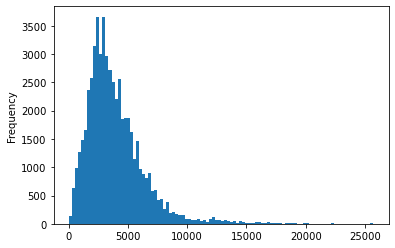

In [9]:
data['len'].plot.hist(bins=100)

In [10]:
data.len.quantile(0.9)

6787.0

## Preprocessing Y Column
We are only going to be classifying conditions for which the count of reviews are more than 3000.

In [11]:
count_df = data[['skill_category','job_description']].groupby('skill_category').aggregate({'job_description':'count'}).reset_index().sort_values('job_description',ascending=False)
count_df.head()

skill_category  job_description
26               Service_Orientation.xls             2948
1                   Active_Listening.xls             2797
27             Social_Perceptiveness.xls             2642
12  Management_of_Material_Resources.xls             2346
20                        Persuasion.xls             2307

In [12]:
target_conditions = count_df[count_df['job_description']>300]['skill_category'].values

In [13]:
target_conditions

array(['Service_Orientation.xls', 'Active_Listening.xls',
       'Social_Perceptiveness.xls',
       'Management_of_Material_Resources.xls', 'Persuasion.xls',
       'Time_Management.xls', 'Complex_Problem_Solving.xls',
       'Negotiation.xls', 'Speaking.xls',
       'Judgment_and_Decision_Making.xls', 'Programming.xls',
       'Learning_Strategies.xls', 'Management_of_Financial_Resources.xls',
       'Coordination.xls', 'Operations_Analysis.xls',
       'Systems_Analysis.xls', 'Critical_Thinking.xls',
       'Systems_Evaluation.xls', 'Monitoring.xls',
       'Technology_Design.xls', 'Active_Learning.xls', 'Instructing.xls',
       'Quality_Control_Analysis.xls', 'Repairing.xls', 'Mathematics.xls',
       'Installation.xls', 'Science.xls', 'Reading_Comprehension.xls',
       'Management_of_Personnel_Resources.xls',
       'Operation_Monitoring.xls', 'Equipment_Maintenance.xls',
       'Troubleshooting.xls', 'Equipment_Selection.xls',
       'Operation_and_Control.xls'], dtype=object)

In [14]:
def condition_parser(x):
    if x in target_conditions:
        return x
    else:
        return "OTHER"
    
'''data['condition'] = data['condition'].apply(lambda x: condition_parser(x))  
data = data[data['skill_category']!='OTHER']'''

"data['condition'] = data['condition'].apply(lambda x: condition_parser(x))  \ndata = data[data['skill_category']!='OTHER']"

In [15]:
data

skill_category                                    job_description  \
0         Mathematics.xls  Be a LEADer. Teach Math at LEAD Public Schools...   
1         Mathematics.xls  Duties \n Summary \n About the Position:  This...   
2         Mathematics.xls  K Health is transforming the world of medicine...   
3         Mathematics.xls  The Lamont-Doherty Earth Observatory in Palisa...   
4         Mathematics.xls  Senior Business Analyst / Lead Business Analys...   
..                    ...                                                ...   
96   Active_Listening.xls  Position Summary Join an elite group of law pr...   
97   Active_Listening.xls  **This position requires relocation to Washing...   
98   Active_Listening.xls  **This position requires relocation to Washing...   
99   Active_Listening.xls  This position is responsible for ensuring qual...   
100  Active_Listening.xls  Position Summary Join an elite group of law pr...   

       len  
0     3364  
1    17097  
2     3076  
3     2940  
4     6326  
..     ...  
96    3026  
97    7277  
98    7418  
99    2099  
100   3026  

[55964 rows x 3 columns]

In [16]:
import plotly.express as px

In [17]:
px.bar(count_df[count_df['job_description']>300],x='skill_category',y='job_description')

In [18]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [19]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [20]:
# lower the text
data["job_description"] = data["job_description"].apply(lambda x: x.lower())

# Clean the text
data["job_description"] = data["job_description"].apply(lambda x: clean_text(x))

# Clean numbers
data["job_description"] = data["job_description"].apply(lambda x: clean_numbers(x))

# Clean Contractions
data["job_description"] = data["job_description"].apply(lambda x: replace_contractions(x))


/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [21]:
data['skill_category']

0           Mathematics.xls
1           Mathematics.xls
2           Mathematics.xls
3           Mathematics.xls
4           Mathematics.xls
               ...         
96     Active_Listening.xls
97     Active_Listening.xls
98     Active_Listening.xls
99     Active_Listening.xls
100    Active_Listening.xls
Name: skill_category, Length: 55964, dtype: object

In [22]:
data=data.fillna('None')

In [23]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['job_description'], data['skill_category'],
                                                    stratify=data['skill_category'], 
                                                    test_size=0.25)

In [24]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (41973,)
Test shape :  (13991,)


In [25]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [26]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [27]:
le.classes_

array(['Active_Learning.xls', 'Active_Listening.xls',
       'Complex_Problem_Solving.xls', 'Coordination.xls',
       'Critical_Thinking.xls', 'Equipment_Maintenance.xls',
       'Equipment_Selection.xls', 'Installation.xls', 'Instructing.xls',
       'Judgment_and_Decision_Making.xls', 'Learning_Strategies.xls',
       'Management_of_Financial_Resources.xls',
       'Management_of_Material_Resources.xls',
       'Management_of_Personnel_Resources.xls', 'Mathematics.xls',
       'Monitoring.xls', 'Negotiation.xls', 'None',
       'Operation_Monitoring.xls', 'Operation_and_Control.xls',
       'Operations_Analysis.xls', 'Persuasion.xls', 'Programming.xls',
       'Quality_Control_Analysis.xls', 'Reading_Comprehension.xls',
       'Repairing.xls', 'Science.xls', 'Service_Orientation.xls',
       'Social_Perceptiveness.xls', 'Speaking.xls',
       'Systems_Analysis.xls', 'Systems_Evaluation.xls',
       'Technology_Design.xls', 'Time_Management.xls',
       'Troubleshooting.xls'], dtype=

### Load Embeddings


In [28]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = 'glove.6B/glove.6B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [29]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [30]:
np.shape(embedding_matrix)

(67348, 300)

## Pytorch Model - TextCNN

In [68]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

## Train TextCNN Model

In [69]:
n_epochs = 6
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/6 	 loss=1592.8692 	 val_loss=1329.8682  	 val_acc=0.2246  	 time=63.58s
Epoch 2/6 	 loss=1281.8950 	 val_loss=1169.8217  	 val_acc=0.2717  	 time=60.46s
Epoch 3/6 	 loss=1157.0865 	 val_loss=1095.9665  	 val_acc=0.2909  	 time=59.64s
Epoch 4/6 	 loss=1087.0256 	 val_loss=1050.5966  	 val_acc=0.3083  	 time=60.69s
Epoch 5/6 	 loss=1037.1431 	 val_loss=1027.0971  	 val_acc=0.3104  	 time=60.12s
Epoch 6/6 	 loss=1003.4274 	 val_loss=1005.4411  	 val_acc=0.3176  	 time=59.79s


In [70]:
torch.save(model,'textcnn_model')

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning:

Couldn't retrieve source code for container of type CNN_Text. It won't be checked for correctness upon loading.



In [43]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

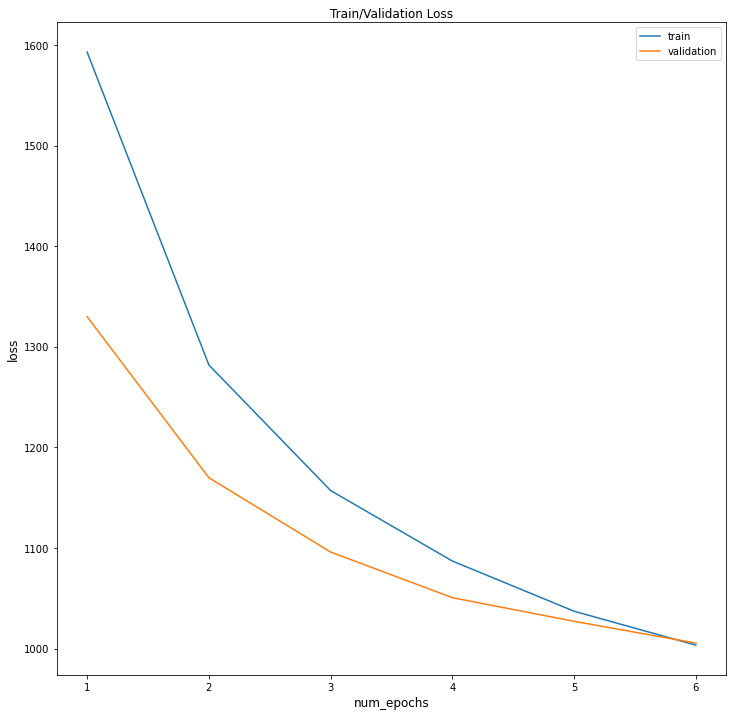

In [72]:
plot_graph(n_epochs)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

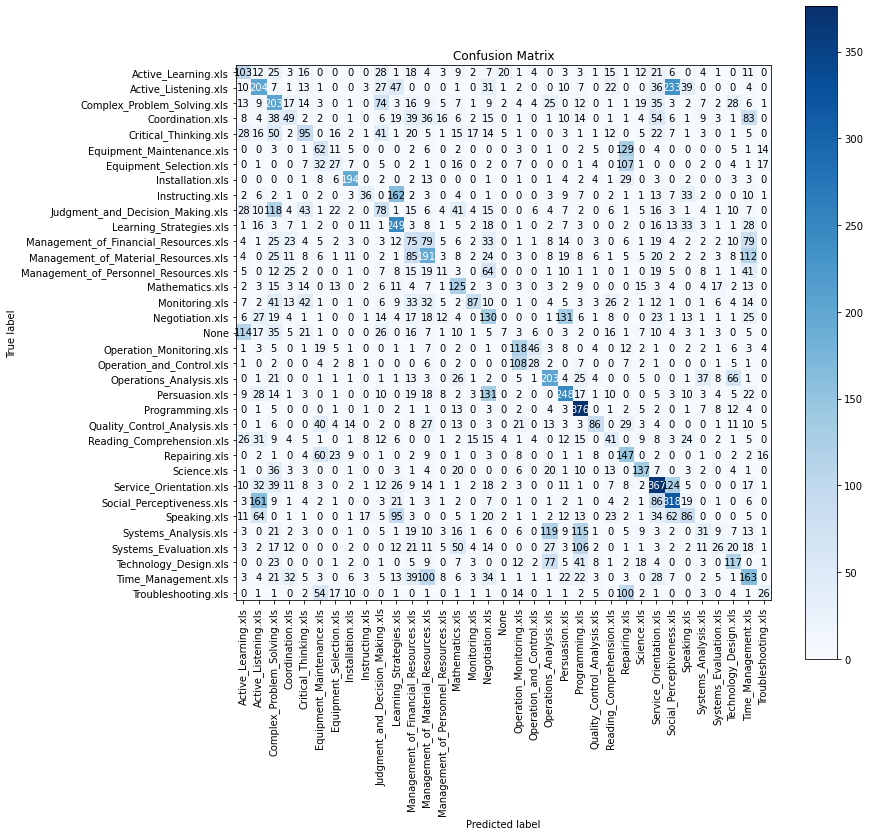

In [74]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

## Pytorch Model - BiLSTM

In [31]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [33]:
n_epochs = 6
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

BiLSTM(
  (embedding): Embedding(120000, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=35, bias=True)
)

In [34]:
# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

In [35]:
# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)


In [37]:
# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=80, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=80, shuffle=False)


In [39]:
y_pred.shape

torch.Size([80, 35])

In [40]:
batch_size

512

In [41]:
train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * 80:(i+1) * 80] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/6 	 loss=198.7798 	 val_loss=186.8528  	 val_acc=0.2544  	 time=44.54s
Epoch 2/6 	 loss=182.0248 	 val_loss=176.0602  	 val_acc=0.2786  	 time=44.21s
Epoch 3/6 	 loss=170.6838 	 val_loss=170.9657  	 val_acc=0.2880  	 time=44.67s
Epoch 4/6 	 loss=161.8241 	 val_loss=163.1807  	 val_acc=0.3076  	 time=45.22s
Epoch 5/6 	 loss=154.6352 	 val_loss=159.0057  	 val_acc=0.3123  	 time=44.57s
Epoch 6/6 	 loss=148.7931 	 val_loss=156.0252  	 val_acc=0.3197  	 time=45.19s


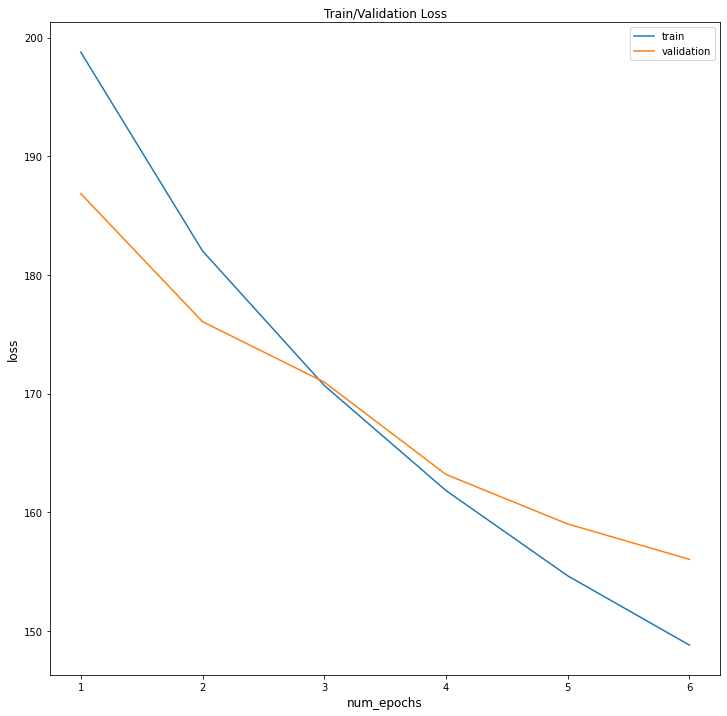

In [44]:
plot_graph(n_epochs)

In [45]:
torch.save(model,'bilstm_model')

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning:

Couldn't retrieve source code for container of type BiLSTM. It won't be checked for correctness upon loading.



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

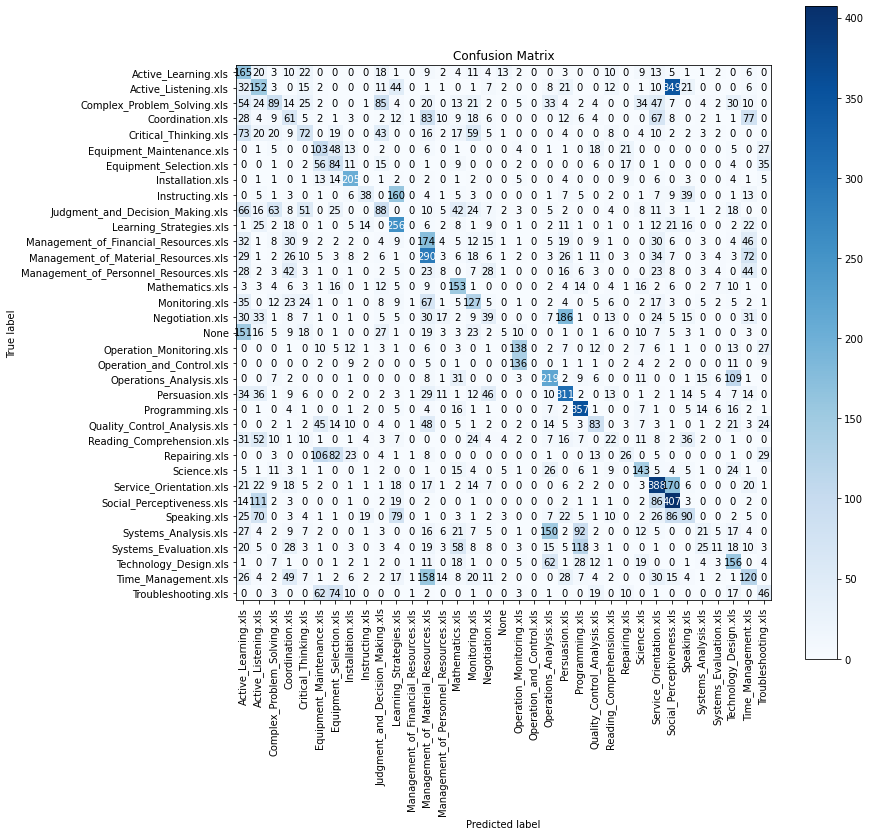

In [46]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

## Deploy : Predict A Single Example

In [47]:
def predict_single(x):    
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [48]:
x = data['job_description'].values[20]
print(x)

about mastery: 
 
we believe educational inequity is the most pressing social problem facing our country and the civil rights issue of our day. mastery exists to help solve this problem. our ultimate goal is to create a model urban school district that serves all students with excellence. we are organized around one driving mission: all students learn the academic and personal skills they need to be truly prepared for postsecondary success and able to pursue their dreams. to fulfill this mission, we attend to the whole child – academically and emotionally – matching high expectations for students with high levels of support. 
 
mastery charter schools is a nonprofit network of more than ## schools serving over ##,### students in philadelphia and camden. we are the largest turnaround school operator in the nation and have been lauded by president obama and the us department of education for our ability to dramatically boost academic achievement in historically low-performing schools. 
 

In [49]:
predict_single(x)

/home/kysha/anaconda3/envs/kyshacuda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



'Mathematics.xls'